In [10]:
!pip install yfinance
!pip install arch
!pip install plotly



You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


     --------------------------------------- 14.8/14.8 MB 25.2 MB/s eta 0:00:00
     ---------------------------------------- 308.9/308.9 KB ? eta 0:00:00


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
from scipy.optimize import minimize

In [6]:
sns.set()

# Statistique descriptives

[*********************100%***********************]  1 of 1 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Likelihood Ratio Statistic: 3.7874
P-value: 0.0516
No significant improvement; prefer the Gumbel model.
Iteration:      1,   Func. Count:      7,   Neg. LLF: 28113145859.77269
Iteration:      2,   Func. Count:     22,   Neg. LLF: 812711630844.2216
Iteration:      3,   Func. Count:     38,   Neg. LLF: 167472353169.15475
Iteration:      4,   Func. Count:     54,   Neg. LLF: 60815188.36599053
Iteration:      5,   Func. Count:     68,   Neg. LLF: 21643277.583337534
Iteration:      6,   Func. Count:     82,   Neg. LLF: -10638.904171624008
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10638.904177454579
            Iterations: 10
            Function evaluations: 82
            Gradient evaluations: 6


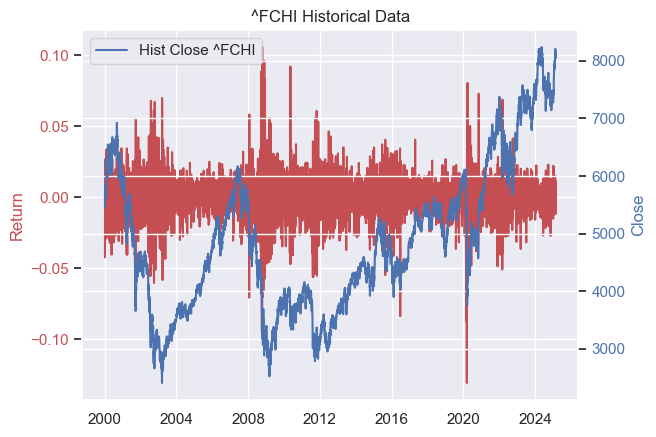

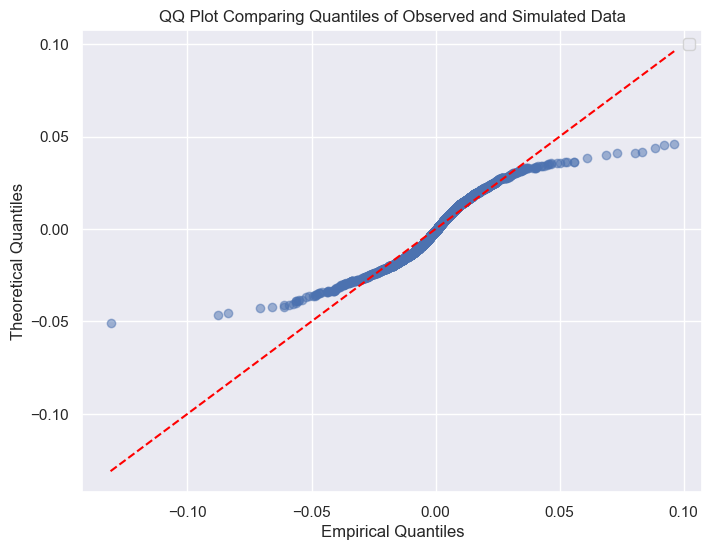

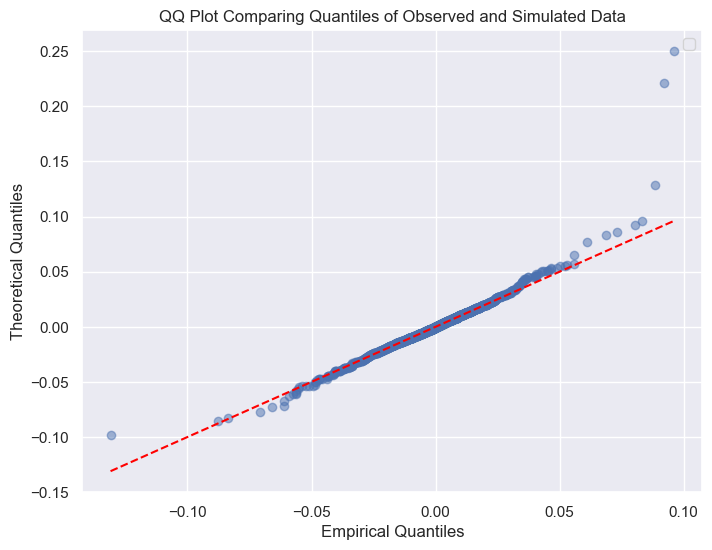

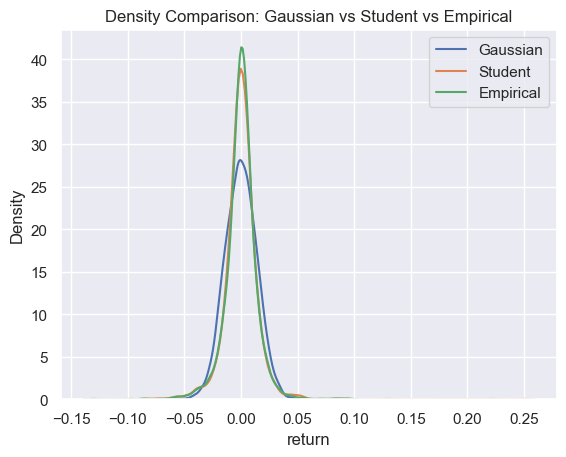

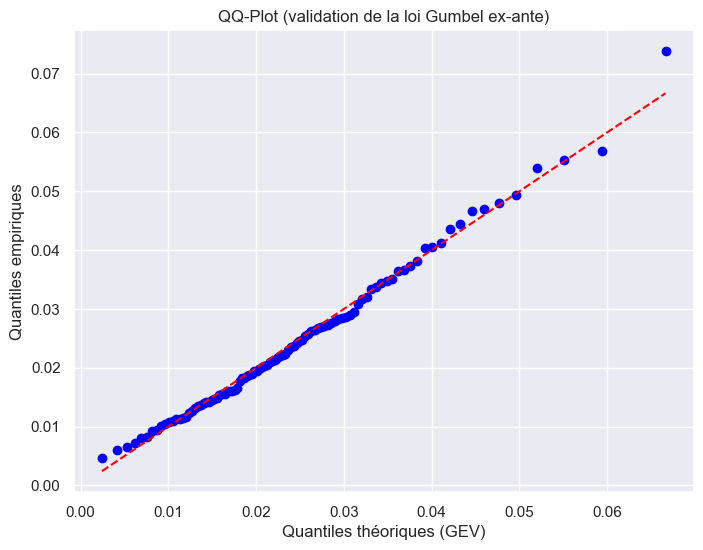

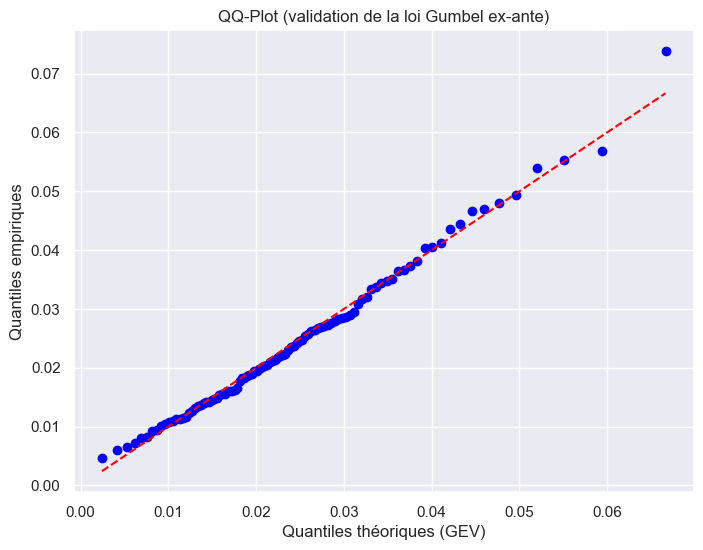

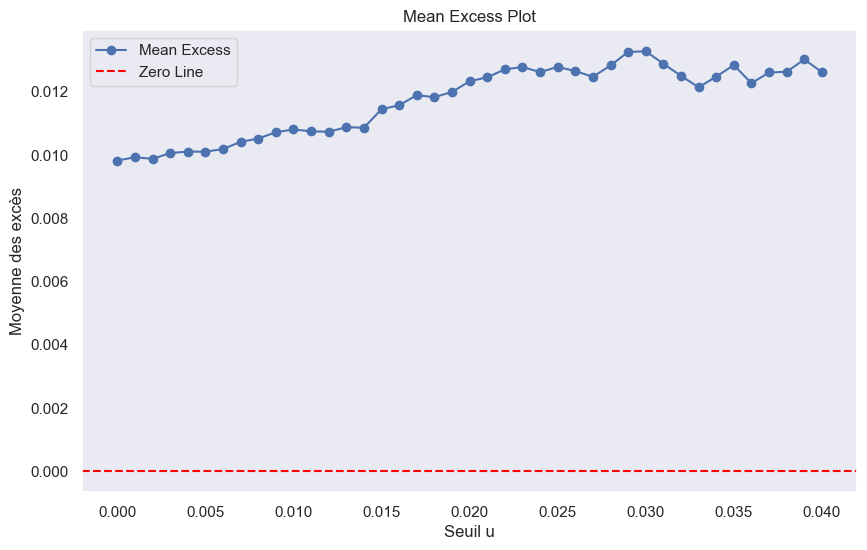

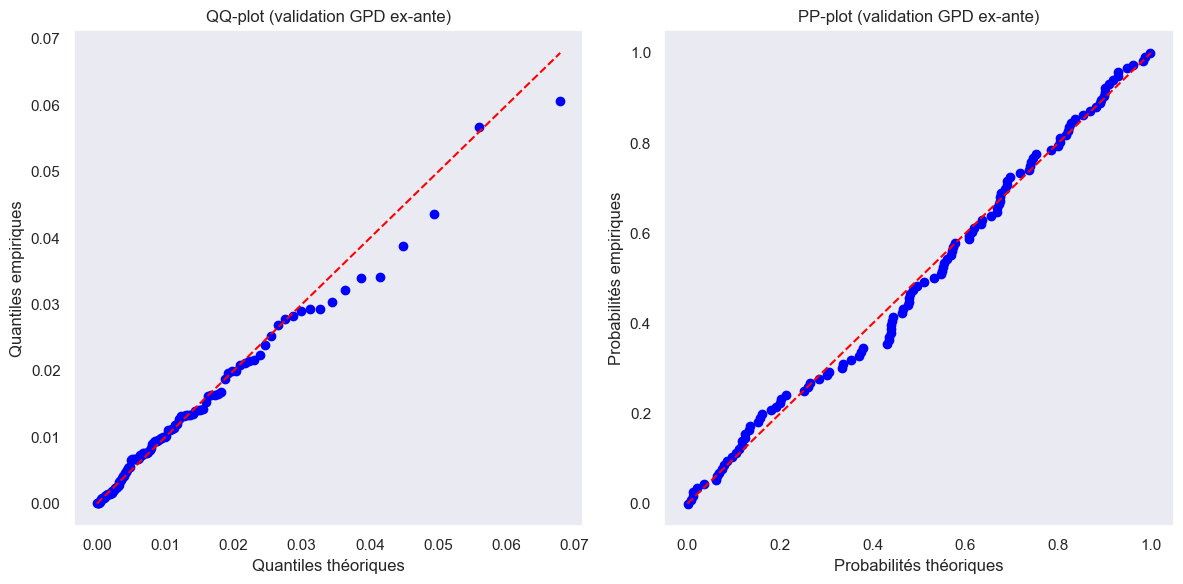

In [28]:
from var import Var # Class implémenatnt toutes les différentes VaR étudiées
import warnings
warnings.filterwarnings("ignore")
ticker = "^FCHI" # "^STOXX50E"
start_date = "2000-01-01"
end_date = pd.Timestamp(datetime.date.today())
start_train, start_test, end_test  = "2008-10-15", "2022-07-26", "2024-06-11"
alpha = 0.99

VaR = Var(ticker, start_date, end_date)
result  = VaR.fit(start_train, start_test, end_test, alpha=alpha)


# VaR non paramétrique

In [13]:
print(f"VaR Historique à {alpha*100}% d'horizon 1 jour :\t", round(result["VaR_hist"],4),"\n")
print(f"ES Historique à {alpha*100}% d'horizon 1 jour :\t", round(result["ES_hist"],4))

VaR Historique à 99.0% d'horizon 1 jour :	 -0.0409 

ES Historique à 99.0% d'horizon 1 jour :	 -0.0547


In [52]:
from pprint import pprint
print(f"VaR Bootstrap à {alpha*100}% d'horizon 1 jour :\t", round(result["VaR_bootstrap"],4))
print("Intervalle de confiance à 90% de la VaR BoostStrap:\n")
pprint(result["VaR_IC"])

VaR Bootstrap à 99.0% d'horizon 1 jour :	 -0.0397
Intervalle de confiance à 90% de la VaR BoostStrap:

{'IC_lower_0.1': np.float64(-0.05115465059489661),
 'IC_upper_0.9': np.float64(-0.029375681894103264),
 'VaR': np.float64(-0.03971167554380373)}


# VaR Gaussienne

In [14]:
print(f"VaR Gaussienne à {alpha*100}% d'horizon 1 jour :\t", round(result["VaR_gaussian"],4),"\n")
print(f"ES empirique {alpha*100}% d'horizon 1 jour :\t", round(result["ES_gaussian"],4))

VaR Gaussienne à 99.0% d'horizon 1 jour :	 -0.0324 

ES empirique 99.0% d'horizon 1 jour :	 -0.0365


Ajustement à la loi gaussienne


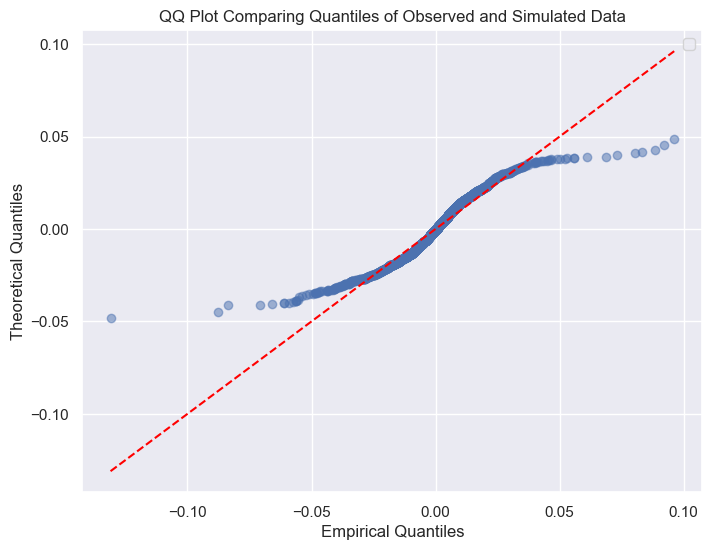

In [15]:
print("Ajustement à la loi gaussienne")
result["qqplot_gaussian"]

### VaR gaussienne à horizon 10 jours par scaling

In [16]:
print(f"VaR Gaussienne à {alpha*100}% d'horizon 10 jours par scaling :\t", round(result["VaR_gaussian_10_day"],4))

VaR Gaussienne à 99.0% d'horizon 10 jours par scaling :	 -0.1026


### VaR gaussienne à horizon 10 jours par méthode de diffusion d'actifs

In [22]:
print(f"VaR Gaussienne à {alpha*100}% d'horizon 10 jours par scaling :\t", round(result["VaR_gaussian_10_day_diff"],4))

KeyError: 'VaR_gaussian_10_day_diff'

# VaR skew-Student

Validation ex-ante de l'ajustement par skew student


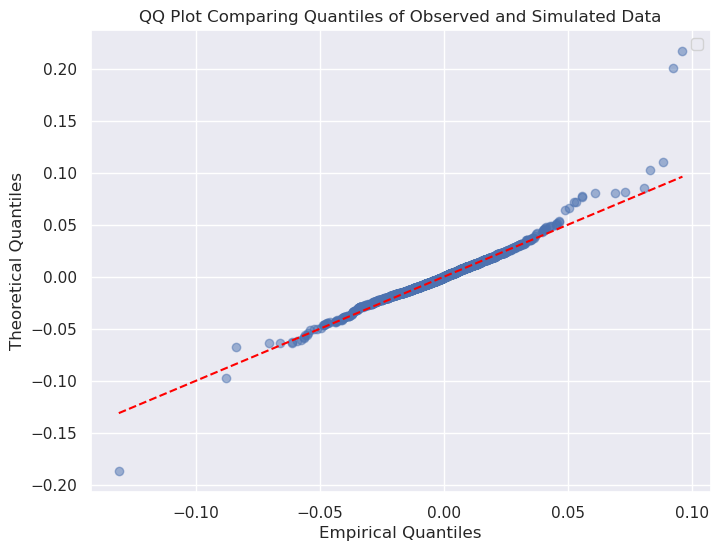

In [56]:
print("Validation ex-ante de l'ajustement par skew student")
result["qqplot_student"]

## Comparaison Ajustement gaussien vs ajustement skew student

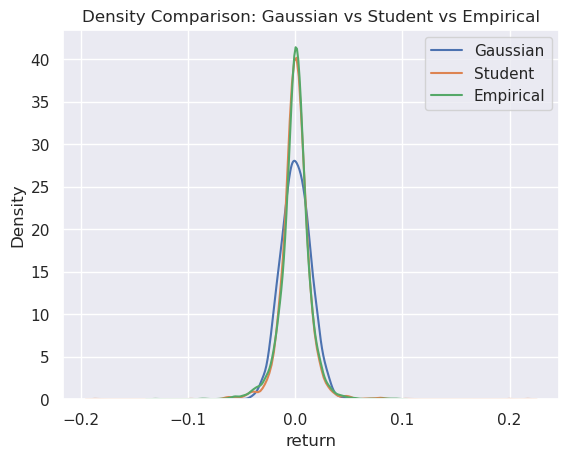

In [57]:
result["Gaussian vs Student calibrations"]

In [68]:
print(f"VaR Skew Student à {alpha*100}% d'horizon 1 jour :\t", round(result["VaR_student"],4))
print(f"ES Skew Student à {alpha*100}% d'horizon 1 jour :\t", round(result["ES_student"],4))

VaR Skew Student à 99.0% d'horizon 1 jour :	 -0.0398
ES Skew Student à 99.0% d'horizon 1 jour :	 -0.0552


# Expected Shortfall

In [62]:
result.keys()

dict_keys(['stats', 'VaR_hist', 'VaR_bootstrap', 'VaR_IC', 'ES_hist', 'VaR_gaussian', 'VaR_gaussian_10_day', 'ES_gaussian', 'VaR_student', 'ES_student', 'qqplot_gaussian', 'qqplot_student', 'Gaussian vs Student calibrations', 'VaR_gev', 'qqplot_gev', 'mrlplot', 'VaR_gpd', 'qqplot_gpd', 'VaR_dyn'])

# Protocole de backtesting

# VaR TVE : Approche Maxima par bloc

Nous partirons d'un bloc de taille 20 jours dans le but d'avoir assez de point pour l'étude, mais aussi de ne pas trop en avoir au risque de garder des valeurs récurrentes non extrêmes.

Plutôt que d'entraîner une Gumbel et une GEV, nous avons opter pour un traitement automatique consistent à estimer les deux modèle et à les comparer sur la base d'un test anova. Ce test permet de confronter l'hypothèse de nullité du paramètre xi Le meilleur modèle est alors celui qui est conservé.

Gumbel plot, GEV


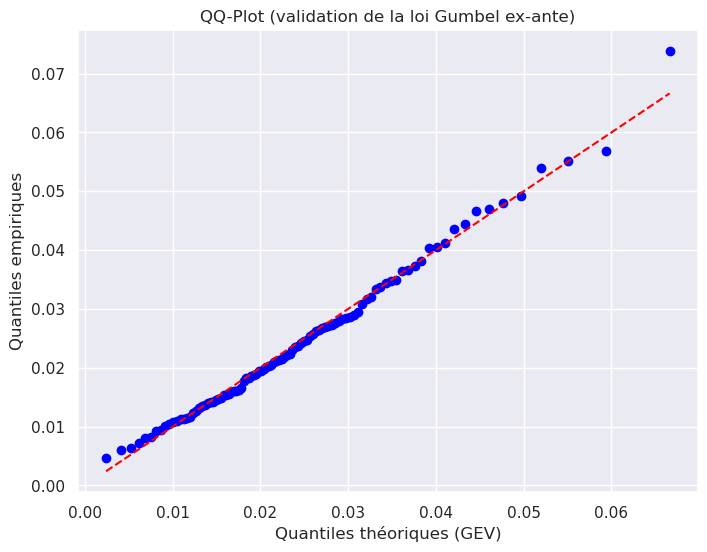

In [70]:
print("Gumbel plot, GEV")
result["qqplot_gev"]

Il apparaît que l'ajustement par une Gumbel est prféférable à un ajustement par une GEV.

In [71]:
print(f"VaR TVE à {alpha*100}% d'horizon 1 jour :\t", round(result["VaR_gev"],4))

VaR TVE à 99.0% d'horizon 1 jour :	 -0.0352


# VaR TVE : Approche Peak over threshold

Mean Residual Life plot


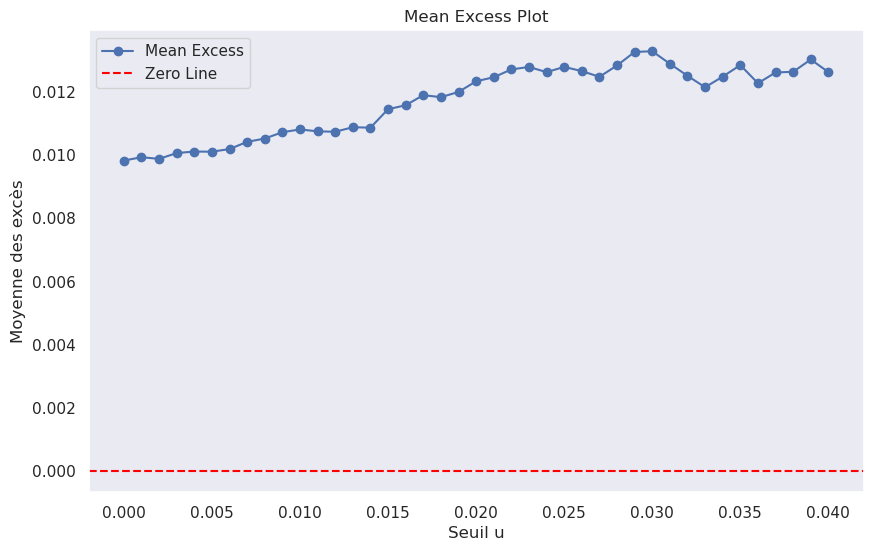

In [72]:
print("Mean Residual Life plot")
result["mrlplot"]

In [ ]:
# Seuil u par analyse graphique: u_opti = 0.028

## Protocole de calibration automatique du seuil u

Afin de déterminer le seuil optimal, il ne doit pas être trop bas pour éviter d’inclure des données trop fréquentes, ni trop élevé afin de conserver suffisamment d'observations pour une modélisation fiable. Pour cette raison, un seuil minimal est fixé au quantile d'ordre 90% et un seuil maximal au quantile 99%. Avec un pas ajustable de 0.0001, nous explorons la plage de valeurs comprises entre u_min et u_max. Pour chaque seuil, nous estimons les paramètres de la loi GPD. Nous calculons ensuite les écarts absolus entre les estimations successives des paramètres scale et shape. Ces écarts sont additionnés pour chaque seuil afin de mesurer la stabilité des estimations. Le seuil optimal correspond à celui où la somme de ces écarts est minimale, indiquant une stabilité maximale des paramètres estimés.

Validation ex-ante de l'ajustement par une GPD


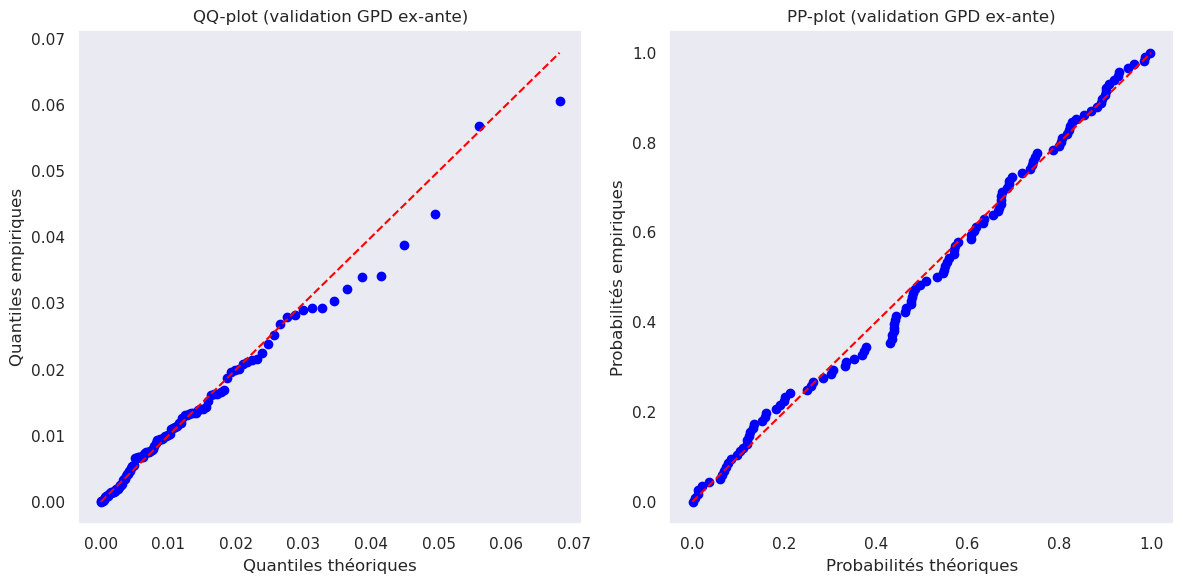

In [73]:
print("Validation ex-ante de l'ajustement par une GPD")
result["qqplot_gpd"]

A gauche on a le QQ-plot et à droite le PP-plot qui montrent un bon ajustement des données à la GPD.

In [74]:
print(f"VaR GPD à {alpha*100}% d'horizon 1 jour :\t", round(result["VaR_gpd"],4))

VaR GPD à 99.0% d'horizon 1 jour :	 -0.0415


# VaR  GARCH

In [75]:
# Recupération des données
data_train, data_test = VaR.train_test_split(start_train=start_train, start_test=start_test, end_test=end_test)

In [50]:
# Var Dynamique
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model


import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox


In [8]:
close_prices = data_train[['return']]

## Applicabilité d’un modèle AR[1]-GARCH[1,1] à la série des log-rendements historiques sur base d’apprentissage

Nous procédons de manière séquentielle par une première spécification consitant 

### Spécification d'un AR(1) et analyse des résidus

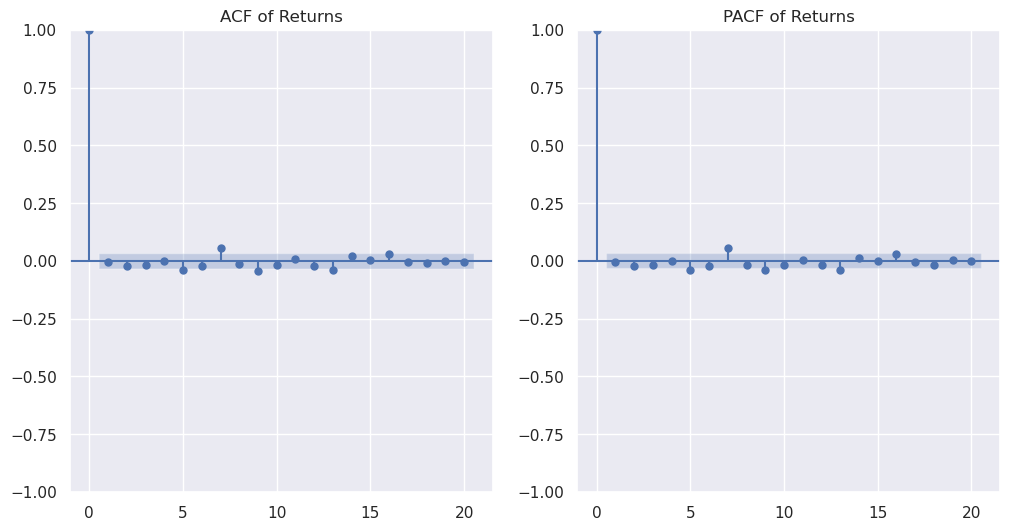

ADF Statistic: -59.760853602606105
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4322085838690244), '5%': np.float64(-2.862361217190852), '10%': np.float64(-2.567207147908185)}


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 3522
Model:                 ARIMA(1, 0, 0)   Log Likelihood               10048.809
Date:                Wed, 26 Feb 2025   AIC                         -20091.617
Time:                        17:48:05   BIC                         -20073.117
Sample:                             0   HQIC                        -20085.017
                               - 3522                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.626      0.532      -0.000       0.001
ar.L1         -0.0037      0.012     -0.319      0.749      -0.027       0.019
sigma2         0.0002   2.16e-06     89.923      0.0

In [9]:
# a. applicabilité d’un modèle AR[1]-GARCH[1,1] à la série des log-rendements historiques sur base d’apprentissage
# Plot ACF and PACF of returns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(close_prices['return'], lags=20, ax=plt.gca())
plt.title('ACF of Returns')

plt.subplot(1, 2, 2)
plot_pacf(close_prices['return'], lags=20, ax=plt.gca())
plt.title('PACF of Returns')
plt.show()

# Stationarity test (ADF test)
adf_result = adfuller(close_prices['return'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

# Fit an AR(1) model
ar_model = ARIMA(close_prices['return'], order=(1, 0, 0)).fit()
print(ar_model.summary())



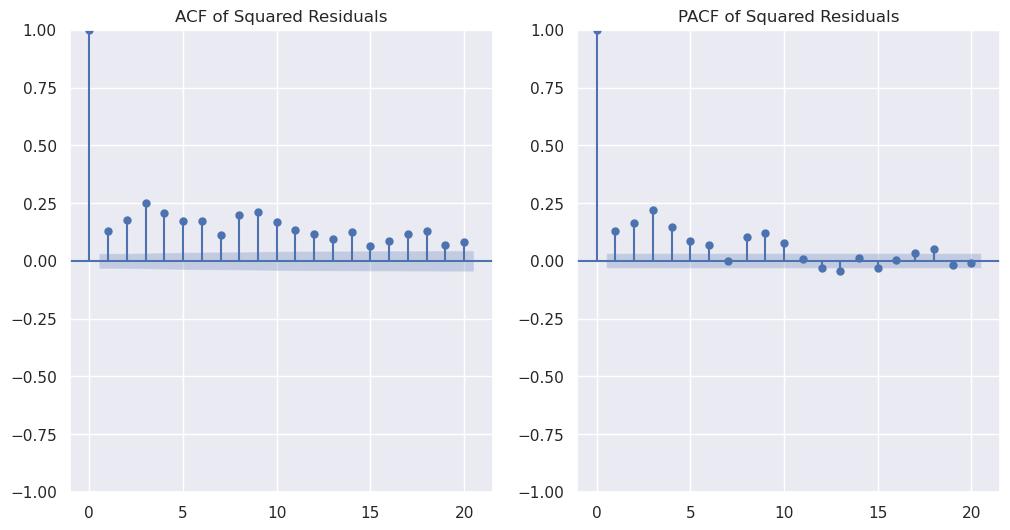

In [10]:
#a. étude de l’homoscedasticité des résidus de l’AR[1]
# Residuals from the AR(1) model
residuals = ar_model.resid

# Plot ACF and PACF of squared residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(residuals**2, lags=20, ax=plt.gca())
plt.title('ACF of Squared Residuals')

plt.subplot(1, 2, 2)
plot_pacf(residuals**2, lags=20, ax=plt.gca())
plt.title('PACF of Squared Residuals')
plt.show()


### Ajustement d'un GARCH(1,1) sur les résidus de l'AR(1) 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20237572423.23587
Iteration:      2,   Func. Count:     20,   Neg. LLF: -10639.883719974014
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10639.883726363387
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10639.9
Distribution:                  Normal   AIC:                          -21271.8
Method:            Maximum Likelihood   BIC:                          -21247.1
                                        No. Observations:                 3522
Date:                Wed, Feb 26 2025   Df Residuals:                     3521
Time:        

/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001947. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




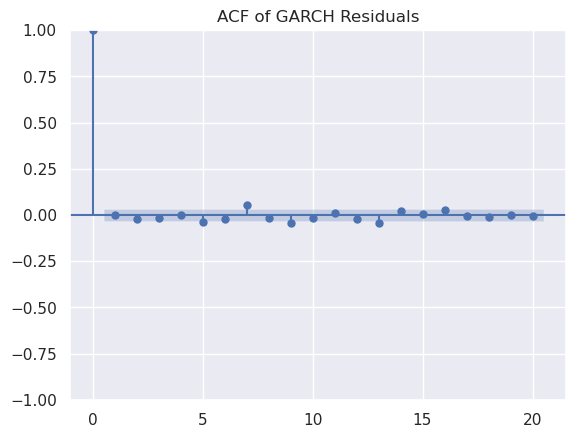

In [11]:
a# b.	Estimer les paramètres du modèle AR[1]-GARCH[1,1] sur base d’apprentissage
# Fit a GARCH(1,1) model on the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()
print(garch_fit.summary())

# Plot ACF of GARCH residuals
garch_residuals = garch_fit.resid
plot_acf(garch_residuals, lags=20)
plt.title('ACF of GARCH Residuals')
plt.show()
    

## Estimation des paramètres du modèle AR[1]-GARCH[1,1] sur base d’apprentissage et analyse des résidus

In [12]:
# c. Vérifier que les résidus de l’AR[1]-GARCH[1,1] sont bien représentatifs d’un bruit blanc i.i.d
# Specify and fit a combined AR(1)-GARCH(1,1) model
# Using the `arch` library, we can directly specify the mean model (AR) and variance model (GARCH)
combined_model = arch_model(close_prices['return'], mean='AR', lags=1, vol='Garch', p=1, q=1)
combined_fit = combined_model.fit()
print(combined_fit.summary())


/opt/conda/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001933. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Iteration:      1,   Func. Count:      7,   Neg. LLF: 28113145859.77269
Iteration:      2,   Func. Count:     22,   Neg. LLF: 812711630844.2216
Iteration:      3,   Func. Count:     38,   Neg. LLF: 167472353169.15475
Iteration:      4,   Func. Count:     54,   Neg. LLF: 60815188.36599053
Iteration:      5,   Func. Count:     68,   Neg. LLF: 21643277.583337534
Iteration:      6,   Func. Count:     82,   Neg. LLF: -10638.904171624008
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10638.904177454579
            Iterations: 10
            Function evaluations: 82
            Gradient evaluations: 6
                           AR - GARCH Model Results                           
Dep. Variable:                 return   R-squared:                      -0.001
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                10638.9
Distribution:                  Normal 

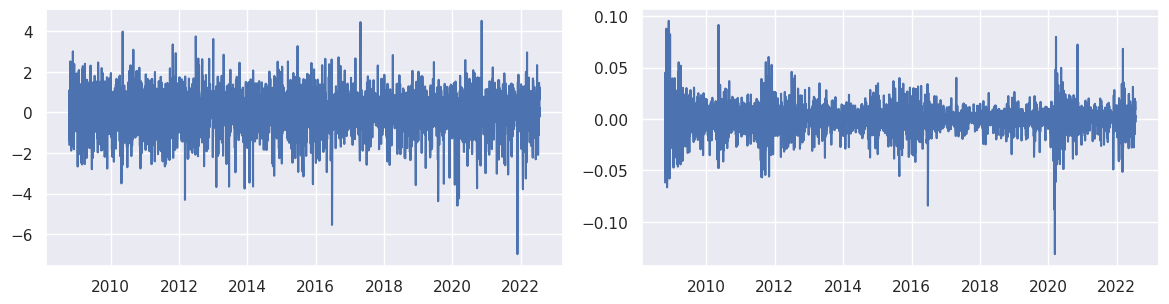

Test de Jarque-Bera:
Statistique: nan, p-value: nan


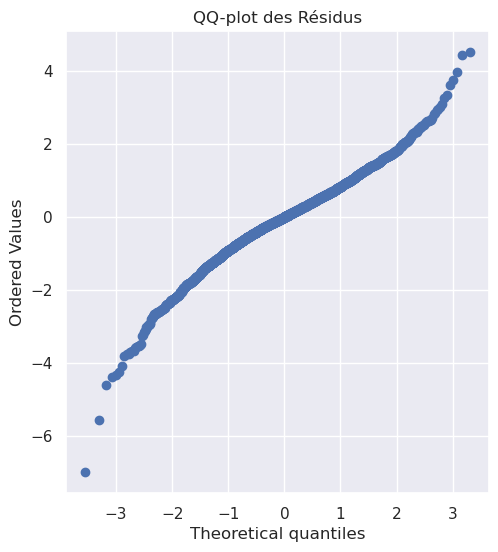

In [14]:


# Extraire les résidus standardisés du modèle AR(1)-GARCH(1,1)
std_residuals = combined_fit.std_resid  # Résidus standardisés
residuals = combined_fit.resid

# 2. Vérifier la normalité des résidus (QQ-plot et test de Jarque-Bera)
plt.figure(figsize=(12, 6))

# QQ-plot
plt.subplot(1, 2, 1)
stats.probplot(std_residuals, dist="norm", plot=plt)
plt.title('QQ-plot des Résidus')

# Test de Jarque-Bera
jb_test = stats.jarque_bera(std_residuals)
print(f"Test de Jarque-Bera:\nStatistique: {jb_test[0]}, p-value: {jb_test[1]}")


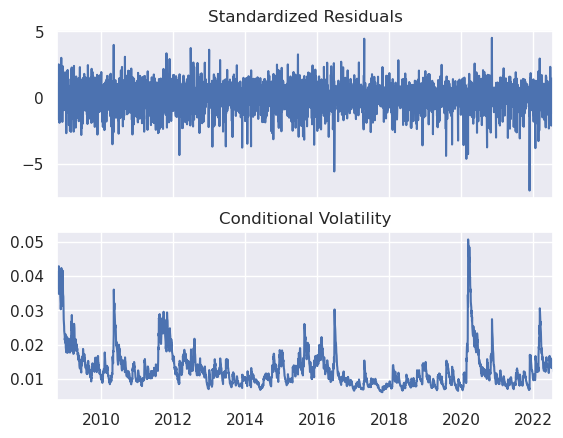

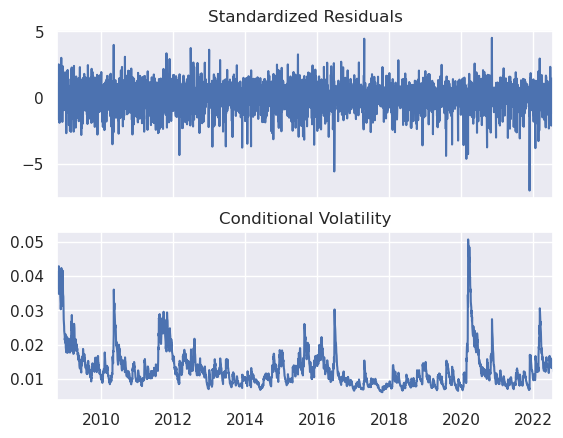

In [15]:
combined_fit.plot()

In [16]:
mu, phi, omega, a, b = combined_fit.params

In [17]:
combined_fit.params

Const        0.000553
return[1]   -0.003726
omega        0.000004
alpha[1]     0.100000
beta[1]      0.880000
Name: params, dtype: float64

In [18]:
data = pd.concat([data_train, data_test])

In [19]:

alpha = 0.99
q = std_residuals.quantile(1-alpha) # Utiliser une GEV ou une GPD à la place

data["mu"] = mu + phi*data["return"].shift()
data["mu"][0] = mu

data["vol"] = np.sqrt(omega/(1-a-b))

for t in range(1, len(data)):
    data["vol"][t] = np.sqrt(omega + 
                             a*(data["return"][t-1] - data["mu"][t-1])**2 
                            + b*data["vol"][t-1]**2
                               )
data["VaR"] = data["mu"] + data["vol"]*q


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [20]:
data.head()

,Close,return,mu,vol,VaR
Date,,,,,
2008-10-15,3381.070068,-0.070633,0.000553,0.013904,-0.036499
2008-10-16,3181.000000,-0.060997,0.000816,0.026091,-0.068713
2008-10-17,3329.919922,0.045753,0.000781,0.031385,-0.082857
2008-10-20,3448.510010,0.034994,0.000383,0.032755,-0.086907
2008-10-21,3475.399902,0.007767,0.000423,0.032677,-0.086660


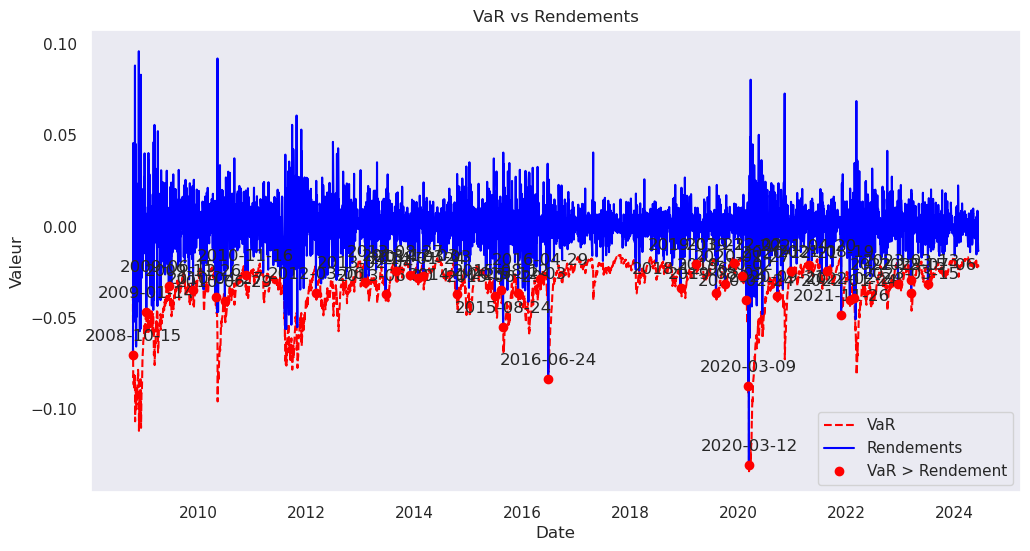

In [21]:
plt.figure(figsize=(12, 6))

# Tracer la VaR et les rendements
plt.plot(data.index, data["VaR"], label="VaR", color="red", linestyle="--")
plt.plot(data.index, data["return"], label="Rendements", color="blue")

# Identifier les points où la VaR excède les rendements
exceedance_points = data[data["VaR"] > data["return"]]

# Marquer ces points avec des points rouges
plt.scatter(exceedance_points.index, exceedance_points["return"], color="red", label="VaR > Rendement", zorder=5)

# Annoter les points critiques
for date, return_value in exceedance_points["return"].items():
    plt.annotate(date.strftime('%Y-%m-%d'), (date, return_value), textcoords="offset points", xytext=(0, 10), ha='center')

# Ajouter des labels et une légende
plt.title("VaR vs Rendements")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid()

# Afficher le graphique
plt.show()


In [ ]:
# VaR Dynamique

In [ ]:
result['VaR_dyn'].show()

# Conclusion